Работа еще требует доработки. В частности, я хочу доделать логику sklearn для первой реализации градиентного спуска. Так как я на тренировочной выборке могу код запустить, а как потом реализовать прогон на тестовой, пока не сильно понимаю (Ну тут та же логика как с линейной регрессией, например. Когда мы берем обучаем модельку на тренировочных данных, смотрим, чтобы она не была сильно переобучена, запоминаем точки, и потом прогоняем на тестовых и валидационных данных. Вот у меня пока не получается сохранить результаты для проверки на тестовых данных. Но есть еще 2 вариант реализации градиентного спуска. На 1 варианте реализации я выявил наилучшие параметры, а на 2 варианте уже подставил их и посмотрел картину на всех выборках. Но это опять же не сильно правильно, так как изменение нужно смотреть на всех выборках сразу. В общем, этот момент нужно исправить.)

1. Рассматриваем малый датасет от MovieLense (лежит на ЯД)

2. Выберите случайным образом 40% пользователей и скройте у них 40% оценок.

3. Скрытые данные отложите, мы будем использовать их как итоговый тест (Final_test_set). 

4. Остальные оценки разделите на 85% (Train_set) и 15% (Validation_set)

5. Возьмиете две реализации, которые мы рассматривали на занятиях для SVD.

6. Сравните реализации и при необходимости улучшите их, по скорости сходимости и RMSE на оценках Train_set и Validation_set.

7. Попробуйте подобрать лучшие параметры для числа скрытых факторов и скорости обучения (learning ratio). Для градиентного спуска попробуйте несколько стратегий уменьшения шага обучения (зависящего и независящего от величины градиента)

8. Вы берите лучшую модель для SVD.

9. Реализуйте любую модель рекомендации на основе похожести фильмов, используя Train_set.

10. Сравните модель SVD и на основе похожести фильмов по NDCG на Validation_set. 

11. Сравните две модели на Final_test_set. 

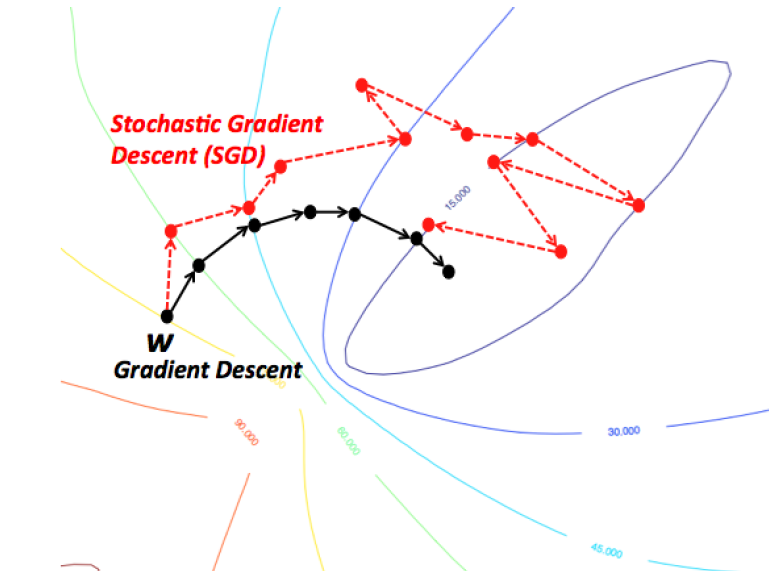

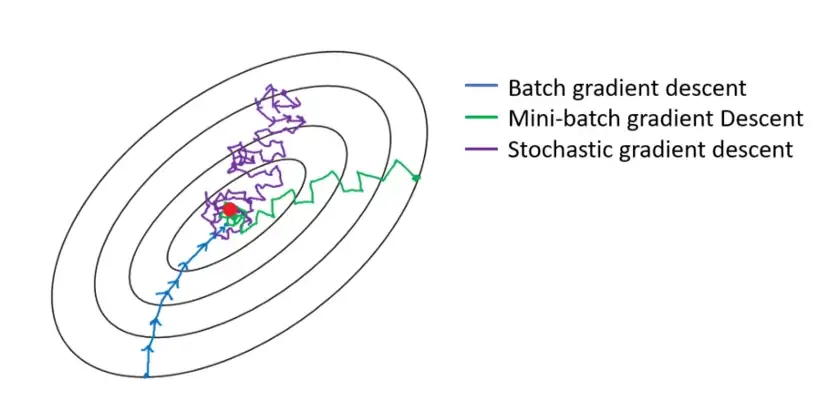

**1) Gradient Descent**: The gradient descent is also known as the batch gradient descent. This optimization algorithm has been in use in both machine learning and data science for a very long time. It involves using the entire dataset or training set to compute the gradient to find the optimal solution. Our movement towards the optimal solution, which could be the local or global optimal solution, is always direct. Using this variant of the model to update for a parameter in a particular iteration requires that we run through all the samples of our training set every time we want to create a single update. However, this can become a major challenge when we have to run through millions of samples. And because a gradient descent example involves running through the entire data set during each iteration, we will spend a lot of time and computational strength when we have millions of samples to deal with. Not only is this difficult, but it is also very unproductive.


**2) Stochastic Gradient Descent**: What is stochastic gradient descent (or SGD, for short)? SGD is a variant of the optimization algorithm that saves us both time and computing space while still looking for the best optimal solution. In SGD, the dataset is properly shuffled to avoid pre-existing orders then partitioned into m examples. This way the stochastic gradient descent python algorithm can then randomly pick each example of the dataset per iteration (as opposed to going through the entire dataset at once). A stochastic gradient descent example will only use one example of the training set for each iteration. And by doing so, this random approximation of the data set removes the computational burden associated with gradient descent while achieving iteration faster and at a lower convergence rate. The process simply takes one random stochastic gradient descent example, iterates, then improves before moving to the next random example. However, because it takes and iterates one example at a time, it tends to result in more noise than we would normally like.


**3) Mini-Batch Gradient Descent**: A mini-batch gradient descent is what we call the bridge between the batch gradient descent and the stochastic gradient descent. The whole point is like keeping gradient descent to stochastic gradient descent side by side, taking the best parts of both worlds, and turning it into an awesome algorithm. So, while in batch gradient descent we have to run through the entire training set in each iteration and then take one example at a time in stochastic, mini-batch gradient descent simply splits the dataset into tiny batches. Hence, it is not running through the entire sample at once, neither is it taking one example at a time. This creates some sort of balance in the algorithm where we can find both the robustness of stochastic and the computational efficiency of batch gradient descent.

https://sdsclub.com/stochastic-gradient-descent-vs-gradient-descent-a-head-to-head-comparison/

In [290]:
import pandas as pd
import numpy as np
from random import random, seed

#### Train, Test, Validation for SGD

In [291]:
def loadMovieLens(path='C:\рекомендательные системы\Homework1\ml-small'):
    movies={}
    skip_first = True
    for line in open(path+'/movies.csv'):
        if skip_first:
            skip_first = False
            continue
        (id,title)=line.split(',')[0:2]
        movies[id]=title

    prefs={}
    skip_first = True
    for line in open(path+'/ratings.csv'):
        if skip_first:
            skip_first = False
            continue
        (user,movieid,rating,ts)=line.split(',')
        prefs.setdefault(user,{})
        #prefs[user][movies[movieid]]=float(rating)
        
        """
        Чтобы затем из словарика сделать датафрейм для ALS, в словарике должен находиться id фильма.
        Кроме как склеить название фильма и его id, а потом из получившейся связки вытащить id, удалить название фильма
        и преобразовать в dataframe, я пока не вижу способов. Из словарика я сделаю dataframe, а сам словарик буду
        использовать дальше для градиентного спуска, так как такой формат является подходящим для реализации. Изначально
        я думал использовать merge и по названию фильма притянуть id из таблицы movies в уже сформированные dataframe
        из словарей, но потом посмотрел, что одному фильму может соответствовать 2 id, и из-за этого могут возникнуть 
        не явные связи, поэтому от такой идеи отказался. 
        """
        
        m = str(movies[movieid]) + "_" + str(movieid)
        prefs[user][m]=float(rating)
        
    return prefs

In [292]:
users = loadMovieLens()

In [293]:
# изначальная длина
len(users)

610

In [294]:
seed(78)
Final_test_set_users = [u for u in users if random() <= 0.4] # отобрали 40% пользователей - Final_test_set

# словарик с 40% пользователей, с полным набором оценок
user_movies_ratings = {}
for u in Final_test_set_users:
    user_movies_ratings[u] = {}
    for m in users[u]:
        user_movies_ratings[u][m] = users[u][m]

In [295]:
Final_test_set = {} # словарик с 40% пользователей, с 60% оценок для каждого пользователя.

part_of_train_set = {} # словарик с 40% пользователей, с оставшимися 40% оценок для каждого пользователя.
for u in user_movies_ratings:
    seed(u)
    movies_test = [m for m in user_movies_ratings[u] if random() <= 0.6] # скрыли 40 % оценок
    part_for_train = list(set([m for m in user_movies_ratings[u]]) - set(movies_test))
    
    Final_test_set[u] = {}
    for m in movies_test:
        Final_test_set[u][m] = users[u][m]
        
    part_of_train_set[u] = {}
    for m in part_for_train:
        part_of_train_set[u][m] = users[u][m]

In [296]:
len(set(users.keys())) == len(list(users.keys())) == (len(set(Final_test_set)) + len(set(users.keys()) - set(Final_test_set))) 

True

In [297]:
# чтобы собрать словарик, который мы будем делить на тестовую и валидационную выборку;
# нужно от изначального датасета users убрать те 40% пользователей, которых мы сложили в отдельную выборку;
# и на месо этих 40% пользователей поместить этих же пользователей, только не со 100% оценок, а с 40%;
# а остальная часть оценок - 60% входит в отложенный датасет с изначально отложенными 40% пользователей;
train_val_df = {}
for u in part_of_train_set:
    train_val_df[u] = {}
    for m in part_of_train_set[u]:
        train_val_df[u][m] = part_of_train_set[u][m]
users_ = list(set(users.keys()) - set(train_val_df.keys()))   
for u in users_:
    train_val_df[u] = {}
    for m in users[u]:
        train_val_df[u][m] = users[u][m]

# Train_set
seed(789)
Train_set_users = [u for u in train_val_df if random() <= 0.85]
Train_set = {}
for u in Train_set_users:
    Train_set[u] = users[u]
    
Train_set_films = []
for u in Train_set:
    for m in Train_set[u].keys():
        if m not in Train_set_films:
            Train_set_films.append(m)
        else:
            continue

# Validation_set
v_users = set(train_val_df.keys()) - set(Train_set.keys())
Validation_set = {}
for u in v_users:
    Validation_set[u] = users[u]
    
Validation_set_films = []
for u in Validation_set:
    for m in Validation_set[u].keys():
        if m not in Validation_set_films:
            Validation_set_films.append(m)
        else:
            continue

In [298]:
len(Validation_set), len(Train_set)

(87, 523)

#### Train, Test, Validation datasets for ALS matrix factorization

In [299]:
# Так как для ALS на вход нужно подать Dataframe, а не набор данных в формате словаря, сделаем преобразование.
def transform(dict_dataset):    
    user=[]
    new_user=[]
    item=[]
    rating=[]
    
    j = 1
    for i in dict_dataset:
        item_id_list = list(dict_dataset[i].keys())
        item += item_id_list
        
        rating_list = list(dict_dataset[i].values())
        rating += rating_list
        
        user_id_list = [i]*len(item_id_list)
        user += user_id_list
        
        new_user_id_list = [j]*len(item_id_list)
        new_user += new_user_id_list
        j += 1
        
    
    df = pd.DataFrame(data={'new_user_id':new_user, 'item':item, 'rating':rating, 'user_id':user})
    df['item_id'] = df['item'].apply(lambda x:x.split("_")[-1])
    df = df.drop(columns=['item'])
    df = df.reindex(columns=['new_user_id', 'item_id', 'rating', 'user_id'])
    df['timestamp'] = None
    df['new_user_id'] = df['new_user_id'].apply(np.int64)
    df['user_id'] = df['user_id'].apply(np.int64)
    df['item_id'] = df['item_id'].apply(np.int64)
    df['rating'] = df['rating'].apply(np.float64)
    
    """
    Возможно нам понадобится для какой-нибудь задачи id пользователя. Например, чтобы сравнить рекомендации проведенные
    разными методами для конкретного пользователя. Поэтому на всякий случай создам справочник с соотнесением старого
    и нового id для каждого user_id
    """
    
    directory_df = df.groupby('new_user_id', as_index=False).agg({'user_id':'max'})
    
    return [df, directory_df]

In [300]:
df_Final_test_set = transform(Final_test_set)[0]
df_Train_set = transform(Train_set)[0]
df_Validation_set = transform(Validation_set)[0]

Собираем матрицу оценок $r_{ij}$

In [301]:
type(df_Train_set['item_id'][1])

numpy.int64

In [302]:
def transform_to_matrix(df):    
    
    n_users = df.user_id.unique().shape[0]
    n_items = df.item_id.unique().shape[0]

    movie_recode = {}
    current_next_free_movie_id = 0
    original_movie_id = []

    # Создаем r_{ui} - нашу матрицу оценок
    ratings = np.zeros((n_users, n_items))
    for row in df.itertuples():
        if (row[2]) not in movie_recode:
            movie_recode[row[2]] = current_next_free_movie_id
            current_next_free_movie_id += 1
            original_movie_id.append(row[2])
        ratings[row[1]-1, movie_recode[row[2]]] = row[3]
    return ratings

In [303]:
train_matrix = transform_to_matrix(df_Train_set)
validation_matrix = transform_to_matrix(df_Validation_set)
final_test_matrix = transform_to_matrix(df_Final_test_set)

In [304]:
train_matrix

array([[3. , 4. , 4.5, ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [4. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [4. , 0. , 0. , ..., 0.5, 4. , 3.5]])

**Здесь проверял, сколько id содержит один фильм.**

In [305]:
df_films = pd.read_csv('ml-small/movies.csv')
df_films = df_films.drop(columns=['genres'])
df_films.title.nunique(), df_films.movieId.nunique()

(9737, 9742)

In [306]:
df_films.groupby('title', as_index=False).agg({'movieId':'count'}).sort_values(by='movieId', ascending=False).head(10)

,title,movieId
1939,Confessions of a Dangerous Mind (2002),2
2723,Emma (1996),2
2785,Eros (2004),2
9287,War of the Worlds (2005),2
7393,Saturn 3 (1980),2
6495,Partisan (2015),1
6490,Parenthood (1989),1
6491,Paris Is Burning (1990),1
6492,"Paris, I Love You (Paris, je t'aime) (2006)",1
6493,"Paris, Texas (1984)",1


### SVD (Gradient)

**Выполненные преобразования:**

* Чтобы не происходило колебание вокруг точки минимума и оптимум находился за меньшее число итераций, мы можем итеративно уменьшать шаг сходимости.


$$ \gamma_n = \frac{1}{min(n+1, mn)}\,,n=0,1,2,...$$

* Градиент также можно зафиксировать и ориентироваться только на его знак. В случае нормировки алгоритм перестает зависеть от величины градиента, а зависит только от его направления, а сходимость определяется только шагом сходимости алгоритма.

Нам нужно контролировать скорость обучения, она со временем должна уменьшаться, тогда наша точность будет расти. Обычно мы должны отслеживать изменения за последние несколько операций. Так как когда мы меняемся слишком быстро или слишком медленно, это не есть хорошо.

Чтобы определить наилучший минимум градиентным спуском, можно запустить сразу несколько потоков (они все равно не пересекутся) из разных точек. Один поток никак не влияет на другой, они удут в параллели. Когда эти потоки сойдутся, на выходе получается сразу несколько локальных минимумов. Если значения оптимизируемой функции примерно одинаковое, значит мы нашли оптимальный или субоптимальный минимум. Если разница все же существенная, возможно следует позапускать градиент еще.

In [375]:
class Gradient():
    def __init__(self,
                grad_type,
                iterations,
                gamma_,
                mn,
                dataset,
                dataset_films):
        self.grad_type = grad_type
        self.iterations = iterations
        self.gamma_ = gamma_
        self.mn = mn
        self.dataset = dataset
        self.dataset_films = dataset_films
                
        self.L = 5 # скрытые параметры
        self.Pi = {} # вектор из 5 параметров пользователя которые соответствуют каждой из его характеристик .
        self.Bi = {} # среднее искажение пользователя. (можно инициализировать средними оценками и т.д)
        self.Ba = {} # среднее искажение фильма
        self.Qa = {} # вектор из 5 параметров фильма которые соответствуют каждой из его характеристик.
        self.rating_list = []
        
        self.rating_val_list = []
        self.dataset_val = Validation_set
        
    def for_validation(self):
        for u in self.dataset_val:
            for m in self.dataset_val[u]:
                self.rating_val_list.append((u,m))
    
        
    def pre_start_func(self):
        for u in self.dataset:
            for m in self.dataset[u]:
                self.rating_list.append((u,m)) # все пары пользователь - фильм, для которых есть оценки
        
        seed(666) 
        for u in self.dataset:
            self.Bi[u] = 0
            self.Pi[u] = []
            for i in range(self.L):
                self.Pi[u].append(random()) # для каждого пользователя создаем вектор из 5 случайных чисел

        for m in self.dataset_films:
            self.Ba[m] = 0 
            self.Qa[m] = []
            for i in range(self.L):
                self.Qa[m].append(random())# для каждого фильма создаем вектор из 5 случайных чисел
    
    def evaluate_ratings_(self, rating_list, critics, Pi, Qa, Bi, Ba, L):
        summ = 0
        for (u,m) in rating_list: # проходимся по всем парам пользователь-фильм и считаем оценку
            rate = Bi[u] + Ba[m] # считаем оценку
            for i in range(L):
                rate += Pi[u][i]*Qa[m][i] # перемножаем вектора: соответствующие координаты польз. и оценки, польз. и фильма
                # и прибавляем базис, зависящий от пользователя и фильма.
            summ += (self.dataset[u][m] - rate)*(self.dataset[u][m] - rate) # возводим в квадрат, вычитая из настоящей оценки
            # (настоящая оценка минус оценка, которую мы посчитали, возведенная в квадрат)
        return summ
    
    def evaluate_ratings_validation(self, rating_list, Pi, Qa, Bi, Ba, L):
        summ = 0
        for (u,m) in rating_list: # проходимся по всем парам пользователь-фильм и считаем оценку
            rate = Bi[u] + Ba[m] # считаем оценку
            for i in range(L):
                rate += Pi[u][i]*Qa[m][i] # перемножаем вектора: соответствующие координаты польз. и оценки, польз. и фильма
                # и прибавляем базис, зависящий от пользователя и фильма.
            summ += (self.dataset_val[u][m] - rate)*(self.dataset_val[u][m] - rate) 
            # возводим в квадрат, вычитая из настоящей оценки
            # (настоящая оценка минус оценка, которую мы посчитали, возведенная в квадрат)
        return summ
        
    
    
    def gradient(self):
        j = 0
        for jjj in range(self.iterations): # random.shuffle() - перемешиваем пары.
            for (u, m) in self.rating_list: # random.shuffle(self.rating_list)
                if self.grad_type == "standart_stochastic":
                    gamma = self.gamma_
                elif self.grad_type == "stochastic_iter_normalized":
                    gamma = 1/min(j+1, self.mn)
                elif self.grad_type == "stochastic_iter":
                    gamma = 1/min(j+1, self.mn)
                rate = self.Bi[u] + self.Ba[m]
                for i in range(self.L):
                    rate += self.Pi[u][i]*self.Qa[m][i]
            ### Посчитали прогноз
                error = rate - self.dataset[u][m] # посчитали ошибку (из нашего прогноза вычитаем реальную оценку) #Train_set
                ###
                deltaBi = gamma*error     
                deltaBa = gamma*error     
                self.Bi[u] -= deltaBi
                self.Ba[m] -= deltaBi
                ### Считаем, на сколько изменились значения
                for i in range(self.L):
                    if self.grad_type == "standart_stochastic":
                        derivative_Qa = error*self.Qa[m][i]
                        derivative_Pi = error*self.Pi[u][i]
                    elif self.grad_type == "stochastic_iter_normalized":
                        derivative_Qa = np.sign(error*self.Qa[m][i]) # нормировка. Теперь алгоритм не зависит от величины град.
                        derivative_Pi = np.sign(error*self.Pi[u][i])
                    elif self.grad_type == "stochastic_iter":
                        derivative_Qa = error*self.Qa[m][i]
                        derivative_Pi = error*self.Pi[u][i]
                    deltaPi = (gamma*derivative_Qa) # error*self.Qa[m][i] - произв
                    deltaQa = (gamma*derivative_Pi)
                    # Находимся в точке, считаем градиенты и только потом делаем шаг.
                    # Сначала считаем дельту, а затем уже применяем ее к оценкам.
                    self.Pi[u][i] -= deltaPi
                    self.Qa[m][i] -= deltaQa
                j += 1

        print(self.evaluate_ratings_(self.rating_list, self.dataset, self.Pi, self.Qa, self.Bi, self.Ba, self.L))
        #print(self.evaluate_ratings_validation(self.rating_val_list, self.Pi, self.Qa, self.Bi, self.Ba, self.L)) 
        
    def return_Pi_Qa(self):
        return [self.Pi, self.Qa]

In [323]:
# стох.град спуск с нормализацией градиента и итеративным уменьшением шага сходимости
g = Gradient("stochastic_iter_normalized", 100, 0.01, 100, Train_set, Train_set_films)
g.pre_start_func()
#g.for_validation()
g.gradient()

227817.61619590706


In [311]:
# MSE на 200 итераций
g.gradient()

777940.9033035567


In [312]:
# MSE на 300 итераций
g.gradient()

403560.0277701053


In [324]:
# стох.град спуск без оптимизации
g2 = Gradient("standart_stochastic", 700, 0.01, 100, Train_set, Train_set_films)
g2.pre_start_func()
g2.gradient()

29969.383514008157


In [325]:
# стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 100)
g3 = Gradient("stochastic_iter", 700, 0.01, 100, Train_set, Train_set_films)
g3.pre_start_func()
g3.gradient()

29975.75098598205


In [326]:
# стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 2000)
g4 = Gradient("stochastic_iter", 700, 0.01, 1000, Train_set, Train_set_films)
g4.pre_start_func()
g4.gradient()

33603.55563498441


In [327]:
# стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 5000)
g5 = Gradient("stochastic_iter", 700, 0.01, 5000, Train_set, Train_set_films)
g5.pre_start_func()
g5.gradient()

49189.54672988086


In [328]:
# стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 200)
g7 = Gradient("stochastic_iter", 700, 0.01, 200, Train_set, Train_set_films)
g7.pre_start_func()
g7.gradient()

29487.585083935734


In [376]:
# стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 200) (5 итераций)
g8 = Gradient("stochastic_iter", 5, 0.01, 200, Train_set, Train_set_films)
g8.pre_start_func()
g8.gradient()

68905.67192704284


Изначально я планировал использовать реализацию градиентного спуска g7, но так как в данном классе пока нет возможности проверить качество на валидационной и тестовой выборке, то во 2 варианте реализации SGD я как раз с итеративным уменьшением шага сходимости до mn = 200 запустил алгоритм на 100 итераций на тренировочной, валидационной и тестовой выборках. По графику ошибки можно заметить, что после пятой итерации ошибка на валидационной и тренировочной выборке начинает сильно различаться, поэтому я решил остановиться на 5 итерациях и создал еще один объект g8, который отличается от g7 только количеством итераций, которые удалось подобрать, посмотрев на ошибки модели на другой реализации.

In [ ]:
"""
g9 = Gradient("standart_stochastic", 100, 0.01, 100, Train_set, Train_set_films)
g9.pre_start_func()
g9.for_validation()
g9.gradient()


Пример создания объекта класса, в котором помимо mse на тренировочной выборке выводится mse на валидационной.
Дополнительно запускаю функцию for_validation для создания пар пользователь-фильм на валидационной выборке.

"""

Разбираясь с тем как проверить модель на валидационных данных, немного зашел в тупик. Я понимаю, что построил модель, прогнал ее на тренировочных данных (в логики sklearn сделал fit модели). Если брать в пример линейную регрессию, то мы с помощью МНК подгоняем прямую к тренировочным данным - fit модели, а затем смотрим как эта прямая будет подходить к валидационным и тестовым данным. Здесь тоже самое, только с градиентным спуском. Нашли какой-то квазиоптимум функции, то есть сделали fit модели. Теперь на сохраненных в объекте класса значения векторов мы должны прогнать валидационные данные. В целом понимаю идею, но пока пытаюсь реализовать. Чтобы не терять время решил на 2ой реализации градиентного спуска использовать тот вариант реализации градиентного спуска, который показал наименьшую ошибку на тестовых данных 1ой реализации.

**Чтобы считать ошибку на валидационных данных, я внутри класса создал функцию evaluate_ratings_validation, которая по входным данным - пара пользователь фильм и 4 сохраненным на тренировочных данных векторам, должна считать метрику. Но в тренировочной выборке у нас абсолютно разные иденификаторы пользователя по сравнению с валидационной выборкой. То есть не сильно понимаю, как для расчета ошибки брать определенные значения векторов, которые будут соответствовать новому считываемому id юзера из валидационной выборки, по которому мы хотим сделать predict?**

Хоть при всех random я ставил seed, но при разных запусках ноутбука значения метрик немного видоизменяются. Но при изменении mse при различных запусках, ошибка при реализации стохастического градиентного спуска с итеративным уменьшением шага сходимости - 1 / min(n+1, 200) пропорционально наименьшая среди 6 реализаций.

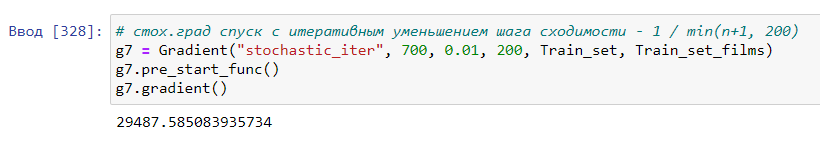

#### Validation and Cross-Validation is used for finding the optimum hyper-parameters and thus to some extent prevent overfitting.

### 
**Validation:**

The dataset divided into 3 sets Training, Testing and Validation. We train multiple models with different hyperparameters with the help of the training set and then test the model with on the validation set. Those hyperparameters are chosen which give good performance on the validation set. Then we use the test set for testing the performance of the model and obtain the generalization error.

**Cross-Validation:**

The dataset divided into 2 parts. One is “Test” and the other for the sake of naming let’s call it X. This X set is then randomly partitioned into complementary sets. We have many models with different hyper-parameters and each model is trained against different combinations of these subsets and validated against the remaining parts. Hyperparameters giving the best results is used further. Final model is trained using these hyperparameters on the full training set (X), and the generalized error is measured on the “Test” set.

When the set X is randomly divided into K subsets and different (K-1) used for training models with different hyperparams and remaning is used for validaiton it is called K-Fold Cross Validation .

Advantage of using Cross-Validation is that we see that we are not wasting any data. In Validation, the data that is being used for validation is being waster and never used for training but in CV we use the validation set also for the training due to the clever manipulation used by us. Data is really important for our model and hence he must use it judiciously.

### SVD (ALS) & (SGD)

In [329]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [347]:
from numpy.linalg import solve

class ExplicitMF():
    def __init__(self, 
                 ratings, # рейтинги
                 n_factors=40, # число факторов - число скрытых переменных. 
                 learning='sgd',
                 item_fact_reg=0.0, 
                 user_fact_reg=0.0,
                 item_bias_reg=0.0,
                 user_bias_reg=0.0,
                 verbose=False):
        
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_fact_reg = item_fact_reg
        self.user_fact_reg = user_fact_reg
        self.item_bias_reg = item_bias_reg
        self.user_bias_reg = user_bias_reg
        self.learning = learning
        self.mn = 200
        
        if self.learning == 'sgd':
            self.sample_row, self.sample_col = self.ratings.nonzero() # nonzero() возвращает id ненулевых элементов массива.
            self.n_samples = len(self.sample_row) # размер матрицы 
        
        elif self.learning == 'sgd_no_bias':
            self.sample_row, self.sample_col = self.ratings.nonzero()
            self.n_samples = len(self.sample_row)
        self._v = verbose

    def als_step(self,
                 latent_vectors,
                 fixed_vecs,
                 ratings,
                 _lambda,
                 type='user'):

        
        if type == 'user':
            # Precompute
            YTY = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(YTY.shape[0]) * _lambda

            for u in range(latent_vectors.shape[0]):
                latent_vectors[u, :] = solve((YTY + lambdaI), 
                                             ratings[u, :].dot(fixed_vecs))
        elif type == 'item':
            # Precompute
            XTX = fixed_vecs.T.dot(fixed_vecs)
            lambdaI = np.eye(XTX.shape[0]) * _lambda
            
            for i in range(latent_vectors.shape[0]):
                latent_vectors[i, :] = solve((XTX + lambdaI), 
                                             ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    
    def train(self, n_iter=10, learning_rate=0.1):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors        
        self.user_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1./self.n_factors, size=(self.n_items, self.n_factors))
        
        if self.learning == 'als':
            self.partial_train(n_iter,0)
        elif self.learning == 'sgd':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = np.mean(self.ratings[np.where(self.ratings != 0)]) # среднее значение оценок по нашей матрице
            self.partial_train(n_iter,0)
        elif self.learning == 'sgd_no_bias':
            self.learning_rate = learning_rate
            self.user_bias = np.zeros(self.n_users)
            self.item_bias = np.zeros(self.n_items)
            self.global_bias = 0 #np.mean(self.ratings[np.where(self.ratings != 0)])
            self.partial_train(n_iter,0)
    
    
    def partial_train(self, n_iter, iter_done):

        ctr = 1
        while ctr <= n_iter:
            if (ctr+iter_done) % 10 == 0 and self._v:
                print (f'\tcurrent iteration: {ctr+iter_done}')
            if self.learning == 'als':
                self.user_vecs = self.als_step(self.user_vecs, 
                                               self.item_vecs, 
                                               self.ratings, 
                                               self.user_fact_reg, 
                                               type='user')
                self.item_vecs = self.als_step(self.item_vecs, 
                                               self.user_vecs, 
                                               self.ratings, 
                                               self.item_fact_reg, 
                                               type='item')
            elif self.learning == 'sgd':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd()
            elif self.learning == 'sgd_no_bias':
                self.training_indices = np.arange(self.n_samples)
                np.random.shuffle(self.training_indices)
                self.sgd(True)
            ctr += 1
    
    # реализация для градиентного спуска        
    def sgd(self, no_bias_estimate = False):
        j = 0
        for idx in self.training_indices:
            u = self.sample_row[idx]
            i = self.sample_col[idx]
            prediction = self.predict(u, i)
            e = (self.ratings[u,i] - prediction) # error
            
            gamma = 1/min(j+1, self.mn) # уменьшение шага градиента.
            
            if not no_bias_estimate:

                # Update biases
                self.user_bias[u] += gamma * (e - self.user_bias_reg * self.user_bias[u])
                self.item_bias[i] += gamma * (e - self.item_bias_reg * self.item_bias[i])
            
            #Update latent factors
            self.user_vecs[u, :] += gamma *\
                                    (e * self.item_vecs[i, :] - self.user_fact_reg * self.user_vecs[u,:])
            self.item_vecs[i, :] += gamma * \
                                    (e * self.user_vecs[u, :] - self.item_fact_reg * self.item_vecs[i,:])
            j += 1
            
    def predict(self, u, i):
        """ Single user and item prediction."""
        if self.learning == 'als':
            return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
        elif self.learning == 'sgd':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
        elif self.learning == 'sgd_no_bias':
            prediction = self.global_bias + self.user_bias[u] + self.item_bias[i]
            prediction += self.user_vecs[u, :].dot(self.item_vecs[i, :].T)
            return prediction
    
    def predict_all(self):
        """ Predict ratings for every user and item."""
        predictions = np.zeros((self.user_vecs.shape[0], 
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)
                
        return predictions
    
    def calculate_learning_curve(self, iter_array, validation, test, learning_rate=0.01):
        iter_array.sort()
        self.train_mse =[]
        self.validation_mse = []
        self.final_test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print (f'Iteration: {n_iter}')
            if i == 0:
                self.train(n_iter - iter_diff, learning_rate)
            else:
                self.partial_train(n_iter - iter_diff, iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.validation_mse += [get_mse(predictions, validation)]
            self.final_test_mse += [get_mse(predictions, test)] # добавил для Теста
            
            if self._v:
                print(f'MSE train:validation: {round(self.train_mse[-1],2)} : {round(self.validation_mse[-1],2)}\n')
                print(f'MSE final_test: {round(self.final_test_mse[-1],2)}\n')
            iter_diff = n_iter

In [348]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=3)
    plt.plot(iter_array, model.validation_mse, \
             label='Validation', linewidth=3)
    plt.plot(iter_array, model.final_test_mse, \
             label='Test', linewidth=3)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('Iterations', fontsize=25);
    plt.ylabel('MSE', fontsize=25);
    plt.legend(loc='best', fontsize=20);

In [349]:
MF_SGD_100 = ExplicitMF(train_matrix, 100, learning='sgd', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]

In [350]:
%%time
MF_SGD_100.calculate_learning_curve(iter_array, validation_matrix, final_test_matrix, learning_rate=0.01)

Iteration: 1
MSE train:validation: 0.83 : 1.14

MSE final_test: 1.11

Iteration: 2
MSE train:validation: 0.79 : 1.19

MSE final_test: 1.16

Iteration: 5
MSE train:validation: 0.74 : 1.27

MSE final_test: 1.23

Iteration: 10
	current iteration: 10
MSE train:validation: 0.7 : 1.32

MSE final_test: 1.29

Iteration: 25
	current iteration: 20
MSE train:validation: 0.54 : 1.39

MSE final_test: 1.36

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:validation: 0.19 : 1.45

MSE final_test: 1.44

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:validation: 0.02 : 1.54

MSE final_test: 1.53

Wall time: 3min 8s


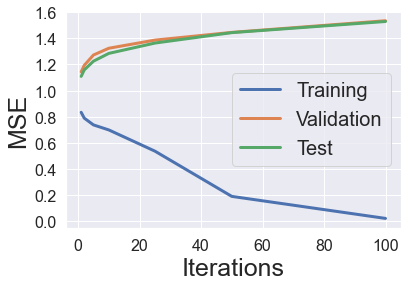

In [351]:
plot_learning_curve(iter_array, MF_SGD_100)

Обучив модель градиентного спуска (1 реализация) на тренировочных данных я выбрал одну из методик - стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 200), которая имела наменьшую ошибку - g7. Так как пока в первой реализации не поучилось добавить в класс паралллельную проверку ошибки на валидационной выборке, я добавил итеративное уменьшение шага сходимости во 2 реализацию градиентного спуска (тут можно посмотреть как изменяется ошибка на тренировочных данных, а вместе с ней и на валидационных). С прохождением большего числа итераций разница в ошибке растет, что может говорить о переобучении. Но если брать значения mse, например, до 5 итерации то разница в ошибке не сильно существенная, поэтому вполне разумно остановиться на 5 шаге и дальше не итерироваться. Ошибка на тестовом датасете практически такая же как и на тренировочном. Так как выходные параметры модели я использую для других задач, то наилучшую модель 1 реализацию градиентного спуска - g7, с которой я собственно и беру вектора, обученные на тренировочных данных, я буду итерировать не 100 раз, а 5 (не стал исправлять g7, а создал новый объект g8). 

In [352]:
# ALS_1
MF_ALS_1 = ExplicitMF(train_matrix, 40, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]

In [353]:
%%time
MF_ALS_1.calculate_learning_curve(iter_array, validation_matrix, final_test_matrix, learning_rate=0.3)

Iteration: 1
MSE train:validation: 5.69 : 13.01

MSE final_test: 12.57

Iteration: 2
MSE train:validation: 4.35 : 13.0

MSE final_test: 12.61

Iteration: 5
MSE train:validation: 4.18 : 12.99

MSE final_test: 12.65

Iteration: 10
	current iteration: 10
MSE train:validation: 4.17 : 13.0

MSE final_test: 12.65

Iteration: 25
	current iteration: 20
MSE train:validation: 4.16 : 13.0

MSE final_test: 12.65

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:validation: 4.16 : 13.0

MSE final_test: 12.65

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:validation: 4.16 : 13.0

MSE final_test: 12.65

Wall time: 6min 37s


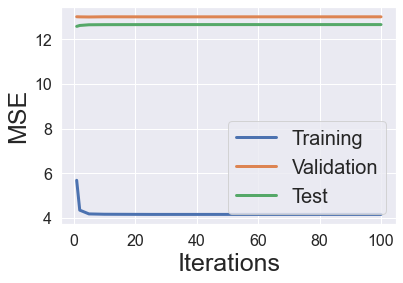

In [354]:
plot_learning_curve(iter_array, MF_ALS_1)

In [344]:
# ALS_2
MF_ALS_2 = ExplicitMF(train_matrix, 5, learning='als', verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]

In [345]:
%%time
MF_ALS_2.calculate_learning_curve(iter_array, validation_matrix, final_test_matrix, learning_rate=0.3)

Iteration: 1
MSE train:validation: 9.49 : 12.99

MSE final_test: 12.64

Iteration: 2
MSE train:validation: 7.56 : 12.81

MSE final_test: 12.45

Iteration: 5
MSE train:validation: 7.26 : 12.9

MSE final_test: 12.46

Iteration: 10
	current iteration: 10
MSE train:validation: 7.21 : 12.9

MSE final_test: 12.47

Iteration: 25
	current iteration: 20
MSE train:validation: 7.2 : 12.89

MSE final_test: 12.47

Iteration: 50
	current iteration: 30
	current iteration: 40
	current iteration: 50
MSE train:validation: 7.2 : 12.89

MSE final_test: 12.47

Iteration: 100
	current iteration: 60
	current iteration: 70
	current iteration: 80
	current iteration: 90
	current iteration: 100
MSE train:validation: 7.2 : 12.89

MSE final_test: 12.47

Wall time: 57.4 s


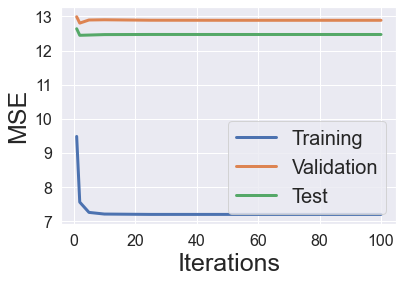

In [346]:
plot_learning_curve(iter_array, MF_ALS_2)

При использовании 5, а не 40 скрытых переменых, ошибка как на тренировочной так и на обучающей выборке меньше. При этом, между двумя выборками при использовании 5 скрытых переменных разница в mse меньше. Различие в mse после пятой итерации становится практически в 2 раза, что может свидетельствовать о переобучении. Наиболее приемлемый результат mse и разница между тренировочной и валидационной выборками находится на 1 и втором шаге итерации в модели с 5 скрытыми переменными. С увеличением шага итерации ошибка и разница между ошибками выборок возрастает.

#### Посмотрим качество ранжирования наилучшей модели на основе SGD с помощью метрики NDCG

In [369]:
# g8 - наилучшая реализация град. спуска
# стох.град спуск с итеративным уменьшением шага сходимости - 1 / min(n+1, 200) на валидационных данных

In [370]:
Pi = g8.return_Pi_Qa()[0]
Qa = g8.return_Pi_Qa()[1]

В зависимости от числа скрытых переменных мы имеем определенное кол-во каких-то фич по юзеру. Я сортирую Qa по id фичи пользователя, которая имела наибольший вес, и вывожу первые рекомендуемые 10 фильмов. Так как это рекомендуемые фильмы, и не факт, что пользователь смотрел определенный фильм, то полностью проставленные оценки для каждого пользователя собрать не получится, поэтому я взял медианную оценку по фильму на тренировочной выборке. В итоге для каждого пользователя есть медианная оценка (рейтинг), которую я затем прогоняю через 

In [371]:
# все оценки по фильмам
def transformPrefs(prefs):
    result={}
    for person in prefs:
        for item in prefs[person]:
            result.setdefault(item,{})
    # Обменять местами человека и предмет
    
            result[item][person]=prefs[person][item]
    return result

for_ndcg = {}
for u in Train_set.keys():
    for_ndcg[u] = {}
    argmax_pi = np.argmax(Pi[u])
    films_recommended = sorted([m for m in Qa], key=lambda x: Qa[x][argmax_pi])[:10]
    for m in films_recommended:
        median_rank = np.median(list(transformPrefs(Train_set)[m].values())) 
        for_ndcg[u][m] = median_rank

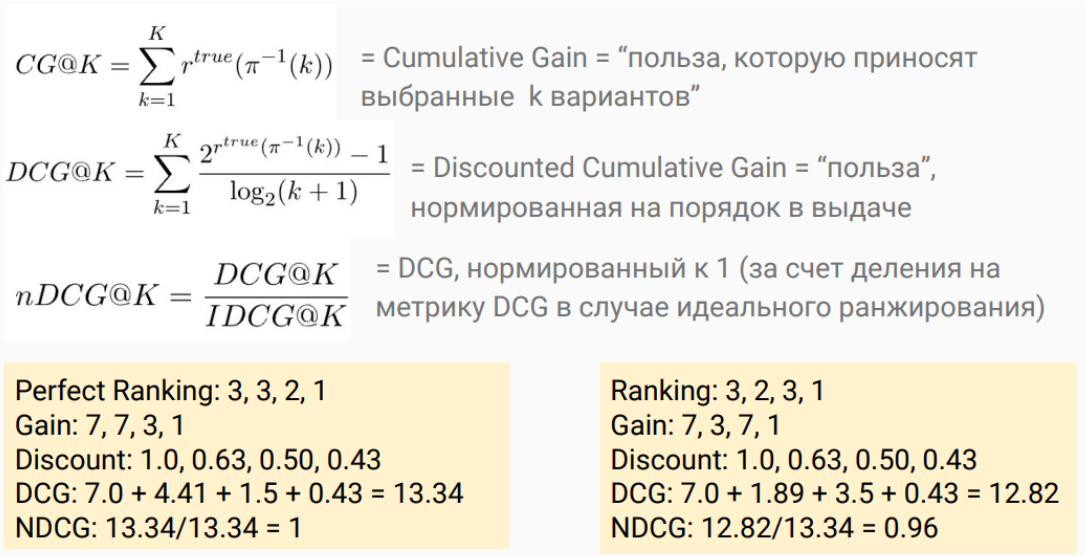

In [372]:
ndcg_list = []

import math
def dcg(ranking):
    gain = [(2**k)-1 for k in ranking]
    discount = [1/math.log2(k+2) for k in range(len(ranking))]
    dcg = sum([gain[i]*discount[i] for i in range(len(ranking))])
    return dcg 

for u in for_ndcg:
    rank = list(for_ndcg[u].values())
    ndcg = dcg(rank)/dcg(sorted(rank, reverse=True)) #sorted(rank, reverse=True) - Perfect ranking
    ndcg_list.append(ndcg)


In [373]:
# Средний ndcg по всем юзерам в тренировочной выборке
np.mean(ndcg_list)

0.8147168979290577

In [374]:
# Медианный ndcg по всем юзерам в тренировочной выборке
np.median(ndcg_list)

0.8140570606656448